In [211]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [212]:
import sys
sys.path.append("..")
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
from example_systems import generate_mackey_glass_system
tau = 20
dt = 1
mg_system_gt = generate_mackey_glass_system(dt,tau)

In [214]:
from helpers import vec

timesteps = np.arange(0.0, 800, step=mg_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 21, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 21, 1))

# initial position and velocity
states_gt[0] = np.zeros((21,1)) + 0.1

# cart acceleration schedule
t = np.min(np.argwhere(timesteps > 1.0))
controls = timesteps

for t in tqdm(range(1, T)):
    if t < (tau):
        x = np.zeros((21,1)) + 0.1
        for i in range(0,t):
            x[20-i,0] = states_gt[i,0,0]
        x = x.reshape((21,))
    else:
        x = np.zeros((21,1))
        x[0,0] = states_gt[t-1,0,0]
        x[1,0] = states_gt[t-2,0,0]
        x[2,0] = states_gt[t-3,0,0]
        x[3,0] = states_gt[t-4,0,0]
        x[4,0] = states_gt[t-5,0,0]
        x[5,0] = states_gt[t-6,0,0]
        x[6,0] = states_gt[t-7,0,0]
        x[7,0] = states_gt[t-8,0,0]
        x[8,0] = states_gt[t-9,0,0]
        x[9,0] = states_gt[t-10,0,0]

        x[10,0] = states_gt[t-11,0,0]
        x[11,0] = states_gt[t-12,0,0]
        x[12,0] = states_gt[t-13,0,0]
        x[13,0] = states_gt[t-14,0,0]
        x[14,0] = states_gt[t-15,0,0]
        x[15,0] = states_gt[t-16,0,0]
        x[16,0] = states_gt[t-17,0,0]
        x[17,0] = states_gt[t-18,0,0]
        x[18,0] = states_gt[t-19,0,0]
        x[19,0] = states_gt[t-20,0,0]

        x[20,0] = states_gt[t-21,0,0]
        x = x.reshape((21,))

    #print(x)

    #x = x.reshape((6,))
    #print(x)
    u = controls[t]

    x_next = mg_system_gt.query_dynamics_model(x, u)
    #print(states_gt[t].shape)
    states_gt[t] = x_next

    z = mg_system_gt.query_measurement_model(x_next)
    measurements[t] = z


100%|██████████| 799/799 [00:00<00:00, 2574.72it/s]


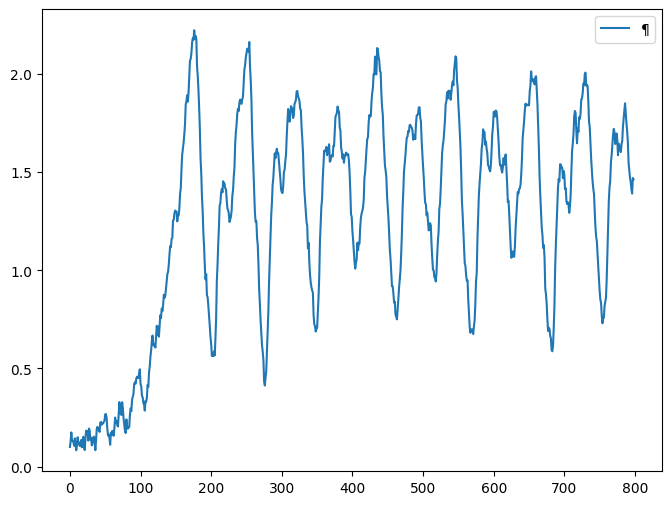

In [215]:
t_max = np.max(np.argwhere(~np.isnan(states_gt[:,0,0])))

if t_max < T-1:
    print("WARNING: System diverges at around t =", t_max)
    t_max -= 10

P_gt = states_gt[:t_max,0,0]

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(timesteps[:t_max], cart_gt, label="cart")
# ax.plot(timesteps[:t_max], cart_vel_gt, label="cart_vel")
ax.plot(timesteps[:t_max], P_gt, label=r"$\P$")
ax.legend(ncol=2)

In [216]:
# Test all filters on same system model approximation
subsample = 1          # filters run at a fraction of sampling rate of the simulation
timesteps_sub = timesteps[::subsample]
states_gt_sub = states_gt[::subsample]
measurements_sub = measurements[::subsample]
controls_sub = controls[::subsample]
T_sub = len(timesteps_sub)

mg_system_approx = generate_mackey_glass_system(dt=mg_system_gt.delta_t * subsample)

In [221]:
# Test all filters with the same initial belief
#initial_covariance = np.diag([0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1,
#                              0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2,
#                              0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3])*0.01
initial_covariance = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,
                              1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,
                              1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,])
initial_mean = np.random.multivariate_normal(states_gt[0,:,0], initial_covariance).reshape(-1, 1)
print(initial_mean)
print(initial_covariance)
initial_state_estimate = (initial_mean, initial_covariance)
#initial_state_estimate

[[0.141087  ]
 [0.09958134]
 [0.13841146]
 [0.10956315]
 [0.14406558]
 [0.08455359]
 [0.14163641]
 [0.05566961]
 [0.09729791]
 [0.0966241 ]
 [0.07985194]
 [0.07118399]
 [0.11204447]
 [0.06286047]
 [0.15664568]
 [0.10172906]
 [0.10188413]
 [0.12730018]
 [0.09755275]
 [0.06094618]
 [0.13971759]]
[[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0. 

In [222]:
def plot_filter_results(mean, filter_name): # Needs to be updated for this system
    fig, (ax1) = plt.subplots()
    fig.suptitle(f"Filtering Results: {filter_name}")

    ax1.set_xlabel("time")
    ax1.plot(timesteps_sub, states_gt_sub[:,0,0])
    ax1.plot(timesteps_sub, mean)
    ax1.set_xlim([0, 800])
    ax1.set_ylim([0, 2.5])

 15%|█▌        | 122/799 [00:00<00:00, 1211.15it/s]

Timestep: 1
Timestep: 2
Timestep: 3
Timestep: 4
Timestep: 5
Timestep: 6
Timestep: 7
Timestep: 8
Timestep: 9
Timestep: 10
Timestep: 11
Timestep: 12
Timestep: 13
Timestep: 14
Timestep: 15
Timestep: 16
Timestep: 17
Timestep: 18
Timestep: 19
Timestep: 20
Timestep: 21
Timestep: 22
Timestep: 23
Timestep: 24
Timestep: 25
Timestep: 26
Timestep: 27
Timestep: 28
Timestep: 29
Timestep: 30
Timestep: 31
Timestep: 32
Timestep: 33
Timestep: 34
Timestep: 35
Timestep: 36
Timestep: 37
Timestep: 38
Timestep: 39
Timestep: 40
Timestep: 41
Timestep: 42
Timestep: 43
Timestep: 44
Timestep: 45
Timestep: 46
Timestep: 47
Timestep: 48
Timestep: 49
Timestep: 50
Timestep: 51
Timestep: 52
Timestep: 53
Timestep: 54
Timestep: 55
Timestep: 56
Timestep: 57
Timestep: 58
Timestep: 59
Timestep: 60
Timestep: 61
Timestep: 62
Timestep: 63
Timestep: 64
Timestep: 65
Timestep: 66
Timestep: 67
Timestep: 68
Timestep: 69
Timestep: 70
Timestep: 71
Timestep: 72
Timestep: 73
Timestep: 74
Timestep: 75
Timestep: 76
Timestep: 77
Timestep

 53%|█████▎    | 424/799 [00:00<00:00, 1425.16it/s]

Timestep: 274
Timestep: 275
Timestep: 276
Timestep: 277
Timestep: 278
Timestep: 279
Timestep: 280
Timestep: 281
Timestep: 282
Timestep: 283
Timestep: 284
Timestep: 285
Timestep: 286
Timestep: 287
Timestep: 288
Timestep: 289
Timestep: 290
Timestep: 291
Timestep: 292
Timestep: 293
Timestep: 294
Timestep: 295
Timestep: 296
Timestep: 297
Timestep: 298
Timestep: 299
Timestep: 300
Timestep: 301
Timestep: 302
Timestep: 303
Timestep: 304
Timestep: 305
Timestep: 306
Timestep: 307
Timestep: 308
Timestep: 309
Timestep: 310
Timestep: 311
Timestep: 312
Timestep: 313
Timestep: 314
Timestep: 315
Timestep: 316
Timestep: 317
Timestep: 318
Timestep: 319
Timestep: 320
Timestep: 321
Timestep: 322
Timestep: 323
Timestep: 324
Timestep: 325
Timestep: 326
Timestep: 327
Timestep: 328
Timestep: 329
Timestep: 330
Timestep: 331
Timestep: 332
Timestep: 333
Timestep: 334
Timestep: 335
Timestep: 336
Timestep: 337
Timestep: 338
Timestep: 339
Timestep: 340
Timestep: 341
Timestep: 342
Timestep: 343
Timestep: 344
Timest

100%|██████████| 799/799 [00:00<00:00, 1443.49it/s]

Timestep: 573
Timestep: 574
Timestep: 575
Timestep: 576
Timestep: 577
Timestep: 578
Timestep: 579
Timestep: 580
Timestep: 581
Timestep: 582
Timestep: 583
Timestep: 584
Timestep: 585
Timestep: 586
Timestep: 587
Timestep: 588
Timestep: 589
Timestep: 590
Timestep: 591
Timestep: 592
Timestep: 593
Timestep: 594
Timestep: 595
Timestep: 596
Timestep: 597
Timestep: 598
Timestep: 599
Timestep: 600
Timestep: 601
Timestep: 602
Timestep: 603
Timestep: 604
Timestep: 605
Timestep: 606
Timestep: 607
Timestep: 608
Timestep: 609
Timestep: 610
Timestep: 611
Timestep: 612
Timestep: 613
Timestep: 614
Timestep: 615
Timestep: 616
Timestep: 617
Timestep: 618
Timestep: 619
Timestep: 620
Timestep: 621
Timestep: 622
Timestep: 623
Timestep: 624
Timestep: 625
Timestep: 626
Timestep: 627
Timestep: 628
Timestep: 629
Timestep: 630
Timestep: 631
Timestep: 632
Timestep: 633
Timestep: 634
Timestep: 635
Timestep: 636
Timestep: 637
Timestep: 638
Timestep: 639
Timestep: 640
Timestep: 641
Timestep: 642
Timestep: 643
Timest

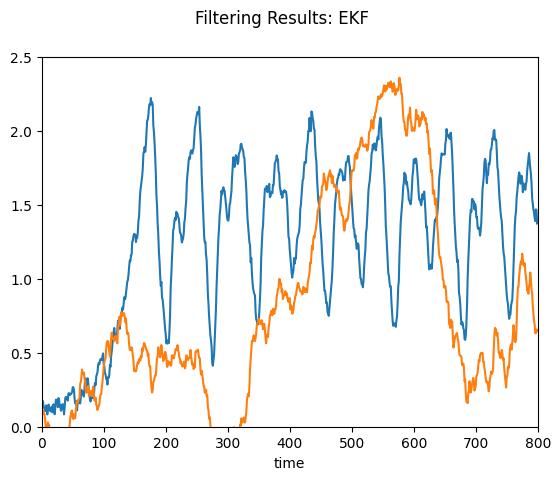

In [228]:
# Run the EKF

from filters import ExtendedKalmanFilter

mg_EKF = ExtendedKalmanFilter(mg_system_approx)

# initial state belief
mg_EKF.initialize(initial_mean,initial_covariance)

means_EKF = np.zeros((T_sub, 21, 1)) + 0.1
covariances_EKF = np.zeros((T_sub, 21, 21))

means_EKF[0] = mg_EKF.mean
covariances_EKF[0] = mg_EKF.covariance

for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]
    z.reshape((21,1))

    print('Timestep: ' + str(int(t)))
    mg_EKF.predict_step(u)
    #mg_EKF.update_step(z)
    
    means_EKF[t] = mg_EKF.mean
    covariances_EKF[t] = mg_EKF.covariance

print("Range Complete!")

# Plot results
plot_filter_results(means_EKF[:,0,0], "EKF")

In [229]:
# Run the UKF

from filters import UnscentedKalmanFilter
mg_UKF = UnscentedKalmanFilter(mg_system_approx)

# initial state belief
mg_UKF.initialize(initial_mean,initial_covariance)

means_UKF = np.zeros((T_sub, 21, 1))
covariances_UKF = np.zeros((T_sub, 21, 21))

means_UKF[0] = mg_UKF.mean
covariances_UKF[0] = mg_UKF.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_UKF.predict_step(u)
    mg_UKF.update_step(z)

    means_UKF[t] = mg_UKF.mean
    covariances_UKF[t] = mg_UKF.covariance


# Plot results
plot_filter_results(means_UKF, "UKF")

  0%|          | 1/799 [00:00<00:05, 143.24it/s]


LinAlgError: 19-th leading minor of the array is not positive definite

In [ ]:
# Run the UKF Variant

from sigma_points import MultiShellSigmaPointSelector

mg_UKF2 = UnscentedKalmanFilter(
    mg_system_approx,
    sigma_point_selector=MultiShellSigmaPointSelector([0.1, 0.5])
)

# initial state belief
mg_UKF2.initialize(*initial_state_estimate)

means_UKF2 = np.zeros((T_sub, 6, 1))
covariances_UKF2 = np.zeros((T_sub, 6, 6))

means_UKF2[0] = mg_UKF2.mean
covariances_UKF2[0] = mg_UKF2.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_UKF2.predict_step(u)
    mg_UKF2.update_step(z)

    means_UKF2[t] = mg_UKF2.mean
    covariances_UKF2[t] = mg_UKF2.covariance


# Plot results
#plot_filter_results(means_UKF2, "UKF2")

: 

In [ ]:
# Error Analysis

errors_EKF = means_EKF - states_gt_sub
errors_UKF = means_UKF - states_gt_sub
errors_UKF2 = means_UKF2 - states_gt_sub

print("EKF Error: ", np.mean(np.linalg.norm(errors_EKF, axis=1)))
print("UKF Error: ", np.mean(np.linalg.norm(errors_UKF, axis=1)))
print("UKF2 Error:", np.mean(np.linalg.norm(errors_UKF2, axis=1)))

: 

: 